In [1]:
# Load pyspark
import findspark

findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import pandas as pd
import numpy as np
import seaborn as sns

import os
import shutil

import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [2]:
df_train = spark.read.parquet("data/01-preprocessed")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 24)


In [3]:
# convert to vector column first
vector_col = "features"
col_names = ['total_cases',
             'year', 'weekofyear',
             'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
             'reanalysis_precip_amt_kg_per_m2',
             'reanalysis_relative_humidity_percent',
             'reanalysis_sat_precip_amt_mm',
             'reanalysis_specific_humidity_g_per_kg',
             'station_avg_temp_c',
             'station_diur_temp_rng_c',
             'station_max_temp_c', 'station_min_temp_c',
             'station_precip_mm',
             'reanalysis_air_temp_c',
             'reanalysis_avg_temp_c',
             'reanalysis_dew_point_temp_c',
             'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
             'reanalysis_tdtr_c'
             ]

assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)

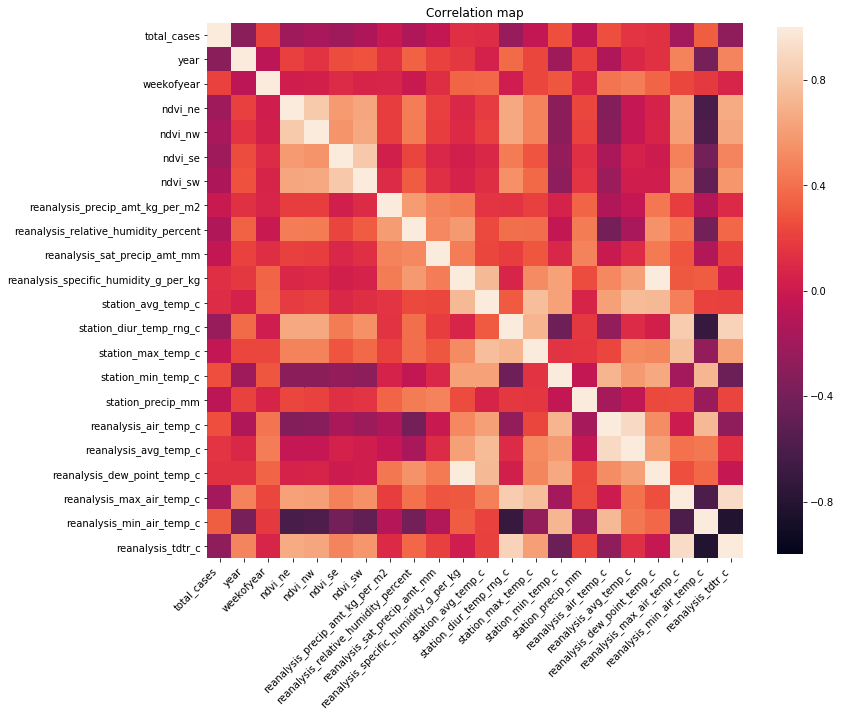

In [4]:
# all
df = df_train

df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
    np.reshape(array, (len(col_names), len(col_names))),
    index=col_names,
    columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45.0,
                   horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.savefig("figs/03-fig_01.pdf", dpi=300, bbox_inches='tight')
plt.show()

### San juan

In [ ]:
# san juan
df_train_sj = df_train.filter(df_train.city == 'sj')
df = df_train_sj

df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
          np.reshape(array, (len(col_names), len(col_names))),
          index=col_names,
          columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map (San Juan)')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97}, annot=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45.0, horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.savefig("figs/03-fig_02.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Iquitos

In [ ]:
# iquitos
df_train_iq = df_train.filter(df_train.city == 'iq')
df = df_train_iq

df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
          np.reshape(array, (len(col_names), len(col_names))),
          index=col_names,
          columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map (Iquitos)')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97}, annot=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45.0, horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.savefig("figs/03-fig_03.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Additional cross validation

In [ ]:
# convert to vector column first
vector_col = "features"
col_names = ['total_cases',
             'station_avg_temp_1_c', 'station_avg_temp_2_c', 'station_avg_temp_3_c', 'station_avg_temp_4_c',
             'd_station_avg_temp_1_c', 'd_station_avg_temp_2_c', 'd_station_avg_temp_3_c', 'd_station_avg_temp_4_c',
             'station_precip_1_mm', 'station_precip_2_mm', 'station_precip_3_mm', 'station_precip_4_mm',
             'd_station_precip_1_mm', 'd_station_precip_2_mm', 'd_station_precip_3_mm', 'd_station_precip_4_mm',
             'reanalysis_sat_precip_amt_1_mm', 'reanalysis_sat_precip_amt_2_mm',
             'reanalysis_sat_precip_amt_3_mm', 'reanalysis_sat_precip_amt_4_mm',
             'd_reanalysis_sat_precip_amt_1_mm', 'd_reanalysis_sat_precip_amt_2_mm',
             'd_reanalysis_sat_precip_amt_3_mm', 'd_reanalysis_sat_precip_amt_4_mm']

assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)

# all
df = df_train

df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
    np.reshape(array, (len(col_names), len(col_names))),
    index=col_names,
    columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map (Iquitos)')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97}, annot=False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45.0,
                   horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.savefig("figs/03-fig_04.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# convert to vector column first
vector_col = "features"
col_names = ['total_cases',
             'year', 'weekofyear',
             'ndvi_ne', 'bucket_ne', 'ndvi_nw', 'bucket_nw',
             'ndvi_se', 'bucket_se','ndvi_sw',
               'bucket_sw']

assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)

# all
df = bucket_iq

df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
          np.reshape(array, (len(col_names), len(col_names))),
          index=col_names,
          columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map (Iquitos)')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97}, annot=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45.0, horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#fig.savefig("figs/03-fig_04.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# convert to vector column first
vector_col = "features"
col_names = ['total_cases',
             'year', 'weekofyear',
             'ndvi_ne', 'bucket_ne', 'ndvi_nw', 'bucket_nw',
             'ndvi_se', 'bucket_se','ndvi_sw',
               'bucket_sw']

assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)

# all
df = bucket_sj

df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
          np.reshape(array, (len(col_names), len(col_names))),
          index=col_names,
          columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map (San Juan)')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97}, annot=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45.0, horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#fig.savefig("figs/03-fig_04.pdf", dpi=300, bbox_inches='tight')
plt.show()